In [86]:
import neurogym as ngym
from neurogym import TrialEnv
import numpy as np

class AnnubesBlock(TrialEnv):
    # DEV: evaluate later on whether we want to keep this as a children of TrialEnv or implement it in the parent class
    # DEV: shuffle_trials functionality is missing
    # DEV: max_sequential functionality is missing
    # DEV: iti functionality is missing
    # EXP: n_outputs and output_behavior functionality is different from the annubes implementation, but I think it is better to keep it this way
    # DEV: scaling functionality is missing
    def __init__(self, session = {"v": 0.5, "a": 0.5}, stim_intensities = [0.8, 0.9, 1.0], stim_time = 1000, decision_time = 100, catch_prob = 0.5, fix_intensity = 0, fix_time = 500, dt = 100, tau = 100, n_outputs = 2, output_behavior = [0, 1], noise_std = 0.01, random_seed = None):
        super().__init__(dt=dt)

        self.session = session
        self.stim_intensities = stim_intensities
        self.stim_time = stim_time
        # EXP: define together the decision time for our tasks; do we want it at all? In their examples, decision time is a period separated from the stimulus, that happend immediately after it.
        self.decision_time = decision_time
        self.catch_prob = catch_prob
        self.fix_intensity = fix_intensity
        # DEV: add range for fix_time
        self.fix_time = fix_time
        self.dt = dt
        self.tau = tau
        self.n_outputs = n_outputs
        self.output_behavior = output_behavior
        self.noise_std = noise_std
        self.random_seed = random_seed
        alpha = dt / self.tau
        self.noise_factor = self.noise_std * np.sqrt(2 * alpha) / alpha
        # Set random state
        # DEV: improve how BaseEnv implements random_seed setting
        if random_seed is None:
            rng = np.random.default_rng(random_seed)
            random_seed = rng.integers(2**32)
        self._rng = np.random.default_rng(random_seed)
        self._random_seed = random_seed
        self.timing = {'fixation': self.fix_time, 'stimulus': self.stim_time, 'decision': self.decision_time}
        # Set the name of each input dimension
        obs_space_name = {'fixation': 0, 'start': 1, 'v': 2, 'a': 3}
        self.observation_space = ngym.spaces.Box(
            low = 0., high = 1., shape = (len(obs_space_name),), name = obs_space_name)
        # Set the name of each action value
        self.action_space = ngym.spaces.Discrete(self.n_outputs, name={'fixation': self.output_behavior[0], 'choice': self.output_behavior})
        # Rewards
        # DEV: Allow to set the rewards from the outside
        # EXP: Define the reward function according to the paper
        self.rewards = {'abort': -0.1, 'correct': +1., 'fail': 0.}

    def _new_trial(self):
        # Setting time periods and their order for this trial
        self.add_period(['fixation', 'stimulus', 'decision'])

        # Adding fixation and start signal values
        self.add_ob(self.fix_intensity, "fixation", where="fixation")
        self.add_ob(1, "stimulus", where="start")

        # Catch trial decision
        catch = self.rng.choice([0, 1], p=[self.catch_prob, 1 - self.catch_prob])
        if not catch:
            stim_type = self.rng.choice(list(self.session.keys()), p=list(self.session.values()))
            stim_value = self._rng.choice(self.stim_intensities, 1)

        for mod in self.session.keys():
            stim = stim_value if not catch and stim_type == mod else 0
            self.add_ob(stim, "stimulus", where=mod)

        if not catch:
            # DEV: verify that this way of adding noise is correct
            self.add_randn(0, self.noise_factor, 'stimulus', where=stim_type)

        # Set ground_truth
        # EXP: Decide together how to define the groundtruth time window
        # DEV: Allow to set the groundtruth from the outside
        # DEV: Consider that the definition of correct choice and action space can be based on more than two output signals (easy case)
        groundtruth = 1 if not catch else 0
        self.set_groundtruth(groundtruth, period='decision', where='choice')

        # Trial information
        # DEV: add meaningful information to trial
        trial = {
            "ground_truth": groundtruth,

        }

        return trial

    def _step(self, action):
        # EXP/DEV: Implement the terminated/truncated condition (it doesn't seem to be implemented in other tasks)
        new_trial = False
        terminated = False
        truncated = False
        reward = 0
        gt = self.gt_now
        if self.in_period('fixation'):
            if action != 0:
                new_trial = False
                reward += self.rewards['abort']
        elif self.in_period('decision'):
            if action != 0:
                new_trial = True
                if action == gt:
                    reward += self.rewards['correct']
                    self.performance = 1
                else:
                    reward += self.rewards['fail']

        return self.ob_now, reward, terminated, truncated, {'new_trial': new_trial, 'gt': gt}

In [87]:
env = AnnubesBlock()
print(env.timing)
print('----------------')
print(env.observation_space)
print(env.observation_space.name)
print('----------------')
print(env.action_space)
print(env.action_space.name)

{'fixation': 500, 'stimulus': 1000, 'decision': 100}
----------------
Box(0.0, 1.0, (4,), float32)
{'fixation': 0, 'start': 1, 'v': 2, 'a': 3}
----------------
Discrete(2)
{'fixation': 0, 'choice': [0, 1]}


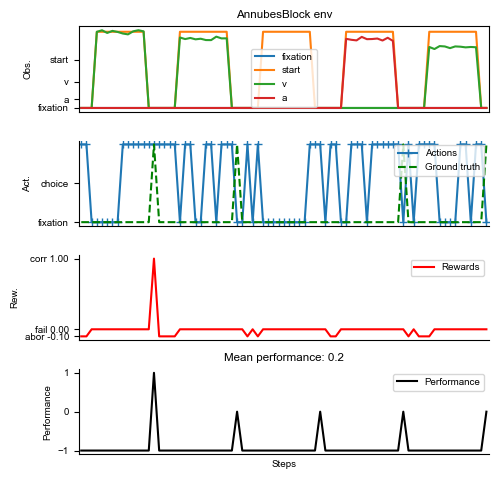

In [90]:
# DEV: Update the plotting functionality to Plotly
# DEV: Remove names on the y-axis for the Observation traces, place dominium numbers instead
# DEV: Add numbers [ms] on the x-axis
fig = ngym.utils.plot_env(
    env,
    ob_traces=['fixation', 'start', 'v', 'a'],
    num_trials=5,
)

In [91]:
import warnings
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C  # ACER, PPO2
warnings.filterwarnings('default')

# Optional: PPO2 requires a vectorized environment to run
# the env is now wrapped automatically when passing it to the constructor
env = DummyVecEnv([lambda: AnnubesBlock()])

model = A2C("MlpPolicy", env, verbose=0)
model.learn(total_timesteps=1000000, log_interval=1000)
env.close()

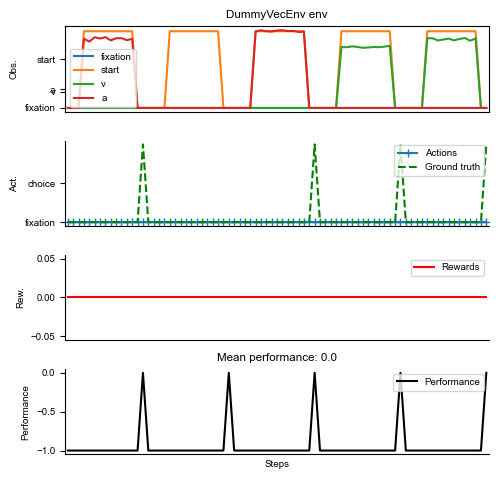

In [94]:
env = AnnubesBlock()
env = DummyVecEnv([lambda: env])
# plot example trials with random agent
data = ngym.utils.plot_env(env, num_trials=5, ob_traces=['fixation', 'start', 'v', 'a'], model=model)